In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv


In [2]:
filename = './videos/gray/selena.avi'

In [3]:
def diff_pixels(frames, params):
    difference = np.abs(frames[1:] - frames[:-1])
    metrics = []

    for diff in difference:
        metrics.append(np.where(diff > params[0], 1, 0).sum())

    return metrics


In [4]:
def reshape(image, rows, cols, size):
    rows, cols = image.shape

    tiled_array = image.reshape(rows // size, size, cols // size, size)
    tiled_array = tiled_array.swapaxes(1, 2).reshape(-1, size, size)
    return tiled_array


def diff_blocks(frames, params):
    rows, cols = frames.shape[1], frames.shape[2]

    trows = rows // params[0]
    tcols = cols // params[0]

    frames = frames[:, :trows * params[0], :tcols * params[0]]
    difference = np.abs(frames[1:] - frames[:-1])
    difference = difference * difference

    metrics = []
    for diff in difference:
        #blocks = diff.reshape(-1, tcols, params[0]).transpose(1, 0, 2).reshape(-1, params[1])
        soma = np.sum(reshape(diff, trows, tcols, params[0]), axis=(1, 2))
        metrics.append((np.sqrt(soma) > params[2]).sum())
    return metrics


In [5]:
def diff_histogram(frames, params):
    total = frames.shape[0]
    histograms = np.empty((total, 256))

    for i in range(total):
        hist, _ = np.histogram(frames[i], bins=256, range=(0, 255))
        histograms[i] = hist

    difference = np.abs(histograms[1:] - histograms[:-1])
    means = np.mean(difference, axis=1)
    stds = np.std(difference, axis=1)
    metrics = means + stds*3
    # metrics = np.sum(difference, axis=1)

    return list(metrics)


In [6]:
def normalize(img_in):
    img_out = np.zeros(img_in.shape, dtype="uint8")

    tmin = img_in.min()
    tmax = img_in.max()

    tsize = abs(tmax - tmin)
    img_out = ((img_in - tmin) * 255) // tsize
    return img_out


def sobelX(img_in):
    res_h = img_in[:, 2:] - img_in[:, :-2]
    res_v = res_h[:-2] + res_h[2:] + 2*res_h[1:-1]
    return np.abs(res_v)


def sobelY(img_in):
    img = img_in.transpose()
    res_h = img[:, 2:] - img[:, :-2]
    res_v = res_h[:-2] + res_h[2:] + 2*res_h[1:-1]
    return np.abs(res_v.transpose())


def sobel(img):
    img = img.astype('int16')
    out = np.zeros(img.shape, int)
    x = sobelX(img)
    y = sobelY(img)

    out[1:-1, 1:-1] = x + y

    return out


In [7]:
def get_metrics(file, shots_size, difference, params, dtype='int16'):
    cap = cv.VideoCapture(file)

    cols = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    rows = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

    shots = np.empty((shots_size + 1, rows, cols), dtype)
    metrics = []

    ret, frame = cap.read()
    first_frame = frame[:,:,0]
    count = 1

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray_frame = frame[:,:,0]
            if count > shots_size:
                shots[0] = first_frame
                first_frame = shots[-1].copy()

                # process shots
                metrics += difference(shots, params)

                shots[1] = gray_frame
                count = 2
            else:
                shots[count] = gray_frame
                count += 1
        else:
            # process shots[:count,:,:]
            shots[0] = first_frame
            metrics += difference(shots[:count, :, :], params)
            cap.release()
            break

    return metrics


In [8]:
def diff_edges(frames, params):
    metrics = []
    for frame in frames:
        mask = normalize(sobel(frame))
        metrics.append((mask > params[0]).sum())
    return metrics


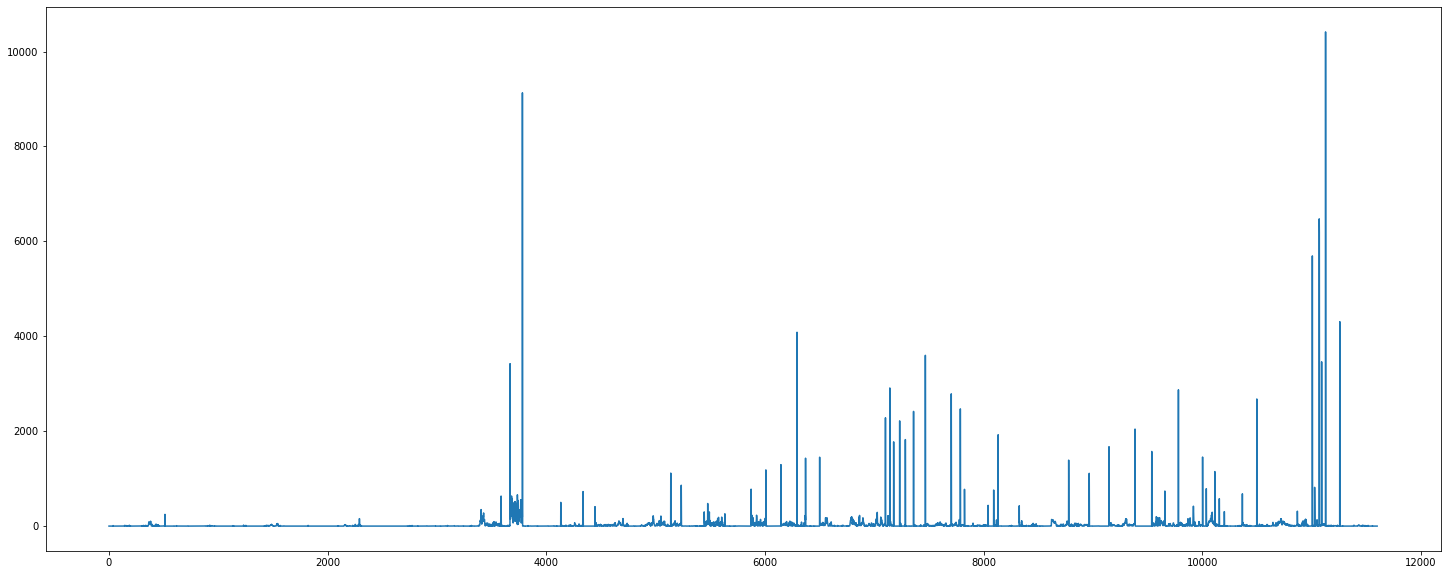

In [9]:
Y = np.array(get_metrics(filename, 512, diff_pixels, [128]))
X = range(len(Y))

plt.figure(figsize=(25,10))
plt.plot(X, Y)

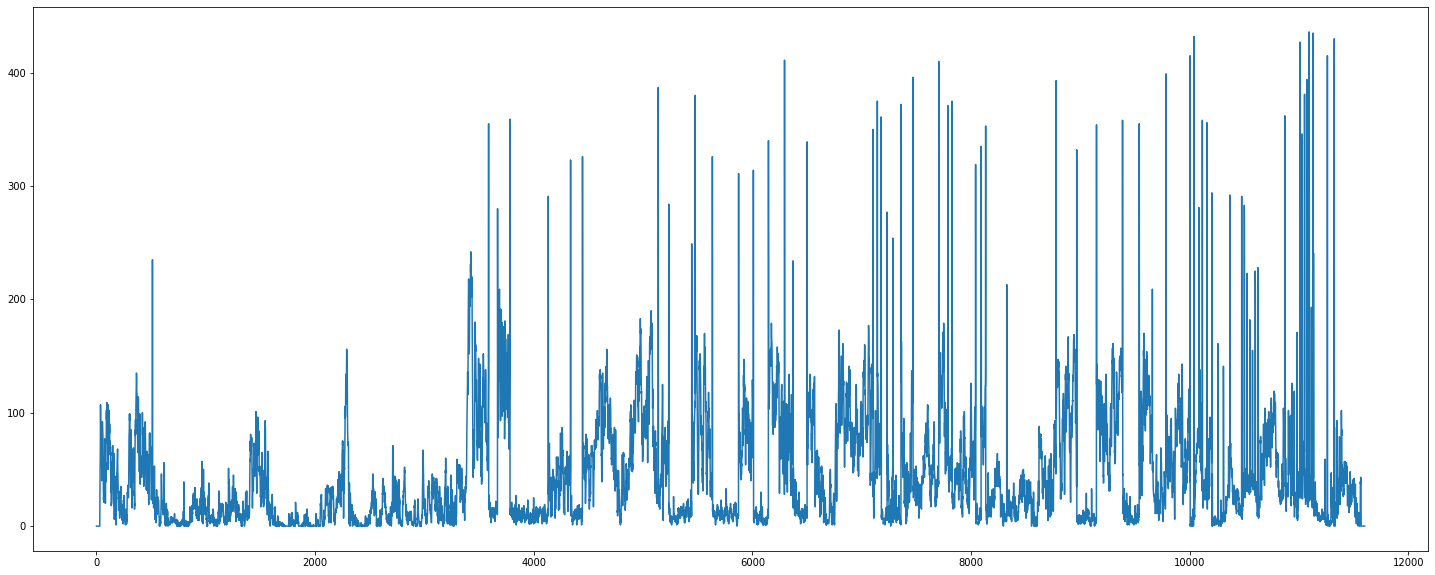

In [10]:
Y = np.array(get_metrics(filename, 512, diff_blocks, [8, 64, 128], 'int32'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)


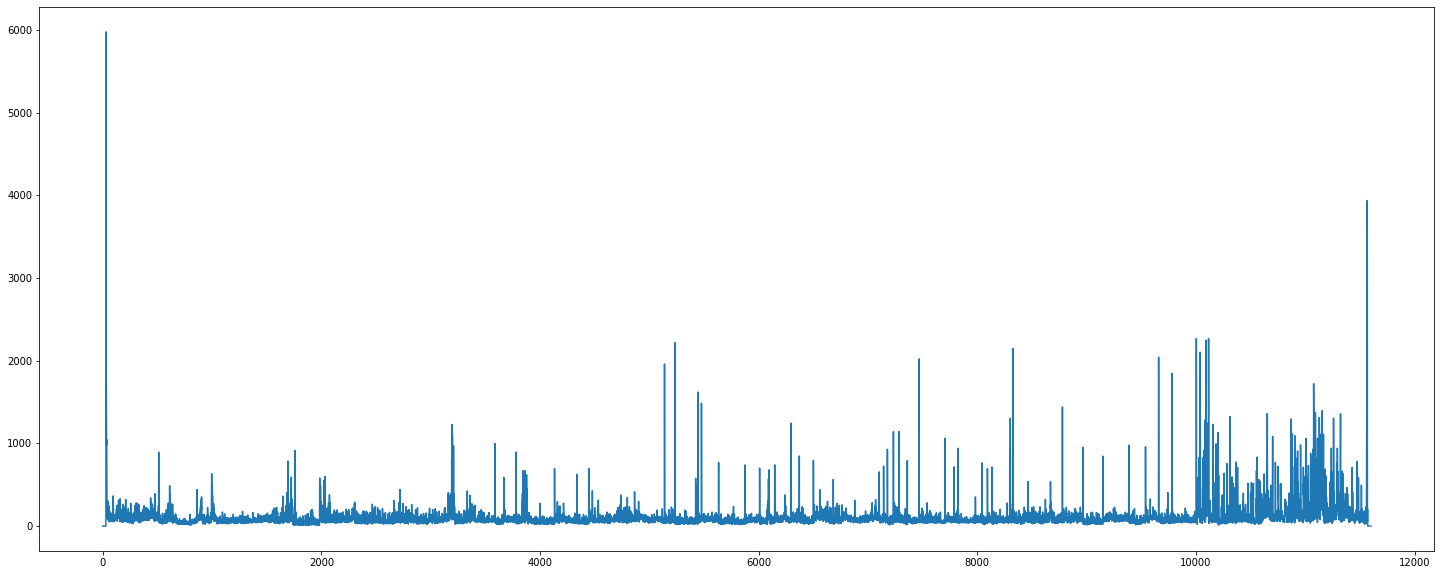

In [11]:
Y = np.array(get_metrics(filename, 64, diff_histogram, [], 'uint8'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)


/tmp/ipykernel_14613/1383514856.py:8: RuntimeWarning: divide by zero encountered in floor_divide
  img_out = ((img_in - tmin) * 255) // tsize


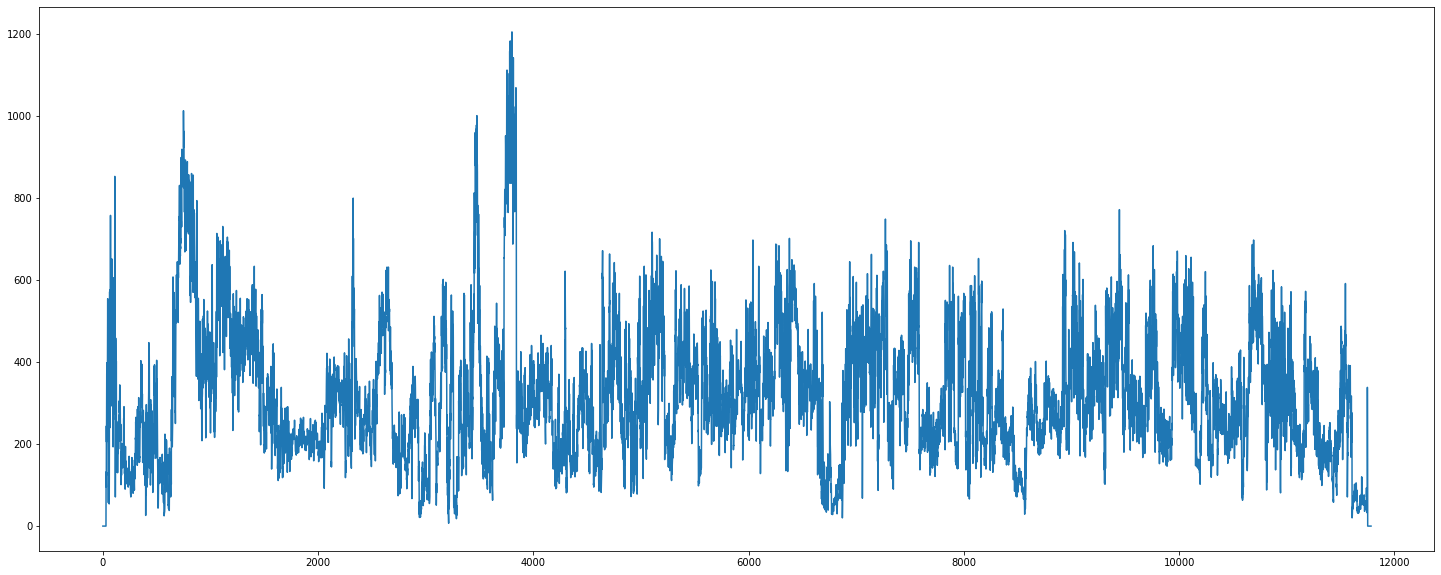

In [12]:
Y = np.array(get_metrics(filename, 64, diff_edges, [128], 'uint8'))
X = range(len(Y))

plt.figure(figsize=(25, 10))
plt.plot(X, Y)
